In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pixelfly.runtime import PixelflyBoard, Mode, BinMode, PixelDepth
from analyze_spots import GridSpotAnalyzer
from homogenize import homogenize
from experiment.session import get_standard_experiment_session

In [49]:
pixelfly = PixelflyBoard(
    name="pixelfly",
    board_number=0,
    mode=Mode.SW_TRIGGER | Mode.ASYNC_SHUTTER,
    exp_time=30,
    hbin=BinMode.BIN_1X,
    vbin=BinMode.BIN_1X,
    gain=False,
    bit_pix=PixelDepth.BITS_12,
)

with pixelfly:
    pixelfly.start_acquisition()

    picture = pixelfly.read_image(1000).astype(float)
    pixelfly.stop_acquisition()


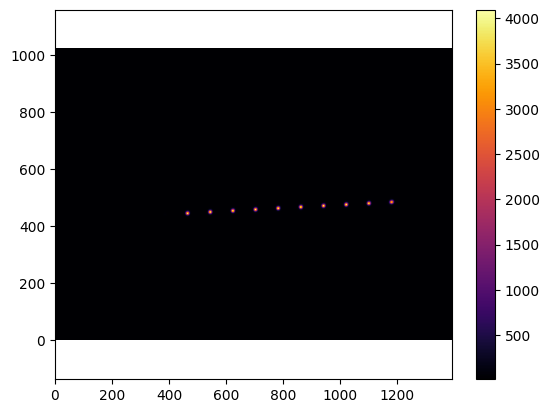

In [50]:
plt.imshow(picture.T, origin="lower", cmap = "inferno")
plt.axis("equal")
plt.colorbar()

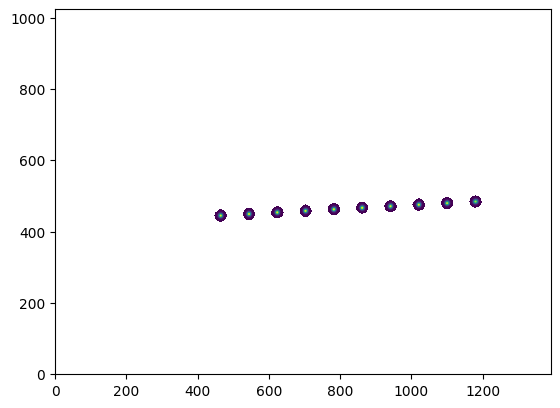

In [51]:
n_rows=1
n_cols=10
m = GridSpotAnalyzer(n_rows, n_cols)
im = m.register_regions_of_interest(picture, relative_threshold=0.27, radius=20)

plt.figure()
plt.imshow(im.T, origin="lower")

intensities = m.compute_intensity_matrix(picture)

(0.0, 358.1358754213037)

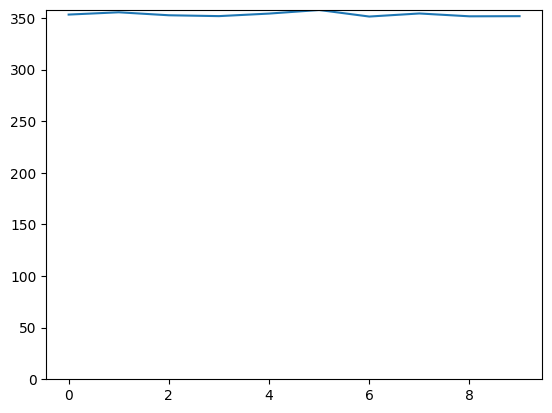

In [52]:
plt.figure()
plt.plot(intensities[:, 0])
plt.ylim(0, None)

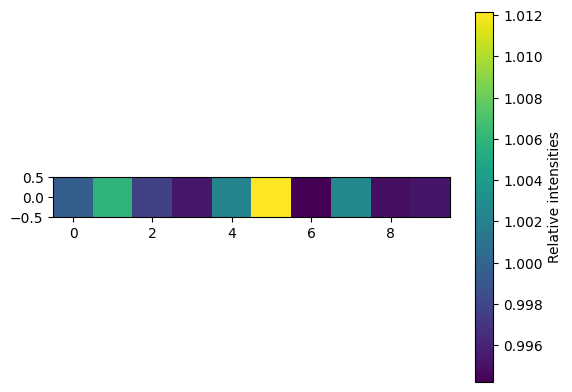

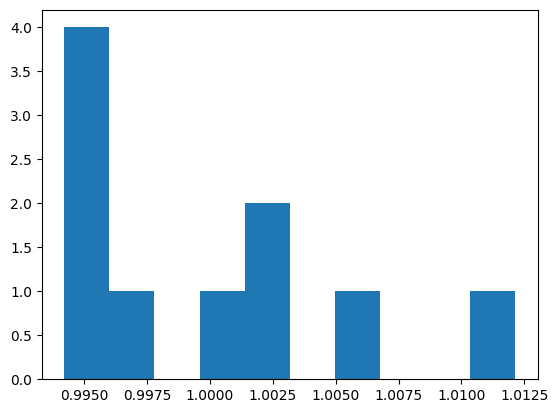

In [53]:
plt.figure()
plt.imshow(intensities.T[::, ::] / np.mean(intensities), origin="lower")
# plt.figure()
# plt.plot(intensities.T)
cb = plt.colorbar()
cb.set_label("Relative intensities")
plt.figure()
plt.hist((intensities.T / np.mean(intensities)).flatten());

In [54]:
intensities

array([[353.39584996],
       [355.60589172],
       [352.72133758],
       [351.89339698],
       [354.35532591],
       [357.8192    ],
       [351.48569157],
       [354.45641838],
       [351.71075697],
       [351.85532591]])

In [40]:
session = get_standard_experiment_session()
with session.activate():
    experiment_config = session.experiment_configs.get_current_config()
    arranger_config = experiment_config.get_device_config("Tweezer arranger")
    tweezer_config = arranger_config["10x1"]

In [41]:
# w = np.ones((5,5))
# w[:,0]*=0.5
intensities, amplitudes_x, amplitudes_y = homogenize(tweezer_config, beta=0.7, exposure=30, roi_radius=20, relative_threshold=0.25)


DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X amplitude: 521 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y amplitude: 165 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Setup step step_0 with StepConfiguration(segment='segment_0', next_step='step_0', repetition=1, change_condition=<StepChangeCondition.ALWAYS: 0>)
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X amplitude: 521 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y amplitude: 165 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Setup step step_0 with StepConfiguration(segment='segment_0', next_step='step_0', repetition=1, change_condition=<StepChangeCondition.ALWAYS: 0>)
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y power for segment segment_0: -5.65 dBm
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Wrote 625248 samples to segment segment_0(0)
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Chann

In [47]:
best_shot = -1#np.argmin(np.var(np.var(intensities, axis=-1), axis=-1))
tweezer_config.amplitudes_x = amplitudes_x[best_shot]
tweezer_config.amplitudes_y = amplitudes_y[best_shot]


In [48]:
with session.activate():
    experiment_config = session.experiment_configs.get_current_config()
    arranger_config = experiment_config.get_device_config("Tweezer arranger")
    arranger_config["10x1"] = tweezer_config
    experiment_config.set_device_config("Tweezer arranger", arranger_config)
    session.experiment_configs.set_current_config(experiment_config)